# **<font color='crimson'>«Настройка NFS и Samba в компьютерной сети»</font>**

---

**Выполнил**: Юмаев Егор

---

## <font color='green'>**ПОСТАНОВКА ЗАДАЧИ**</font>

---

**Цель**: реализовать настройку NFS и Samba в компьютерной сети.

**Задачи**:

- Настроить две виртуальные машины с ролью **server** и **client**.

- Настроить сервер **NFS**.

- Настроить сервер **Samba**.

Использованы виртуальные машины с операционной системой Astra Linux, развернутые в программном продукте для виртуализации VirtualBox.


## <font color='green'>**1 Настройка виртуальных машин**</font>

---

Для выполнения задачи необходимо настроить две виртуальные машины.

Виртуальная машина 1: 	**server**
IP: 					192.168.1.10

Виртуальная машина 2: 	**client**
IP: 					192.168.1.20


Обе виртуальные машины (далее – **ВМ**) получены путем клонирования исходного дистрибутива с ОС Astra Linux.

В настройках ВМ **server** в подразделе Network активируем три адаптера:
Adapter1: Bridged Adapter
Adapter 2: Internal Network
Adapter 3: Internal Network

Меняем имя хоста на ВМ **server**.


In [ ]:
```bash
sudo hostnamectl set-hostname server
```

Создаем соответствующую запись для **server** в файле /etc/hosts.

In [ ]:
```bash
sudo vim /etc/hosts

127.0.0.1		localhost
192.168.1.10	server
```

Выведем информацию о сетевых соединениях на ВМ **server**.

In [ ]:
```bash
nmcli con sh
```

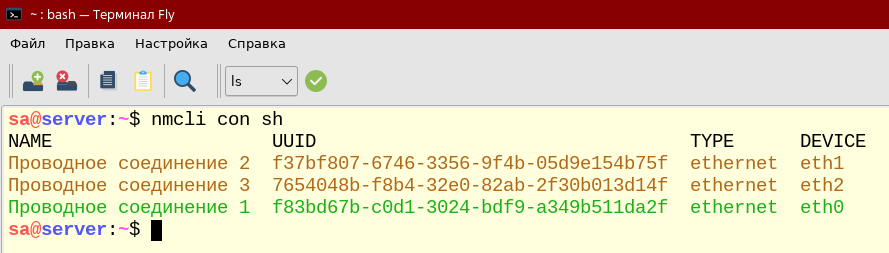

Изменяем имена соединений в NetworkManager на net1, net2, net3, чтобы названия сетевых соединений для первого (eth0), второго (eth1) и третьего (eth3) интерфейсов имели вид net1, net2, net3.

In [ ]:
```bash
nmcli con mod "Проводное соединение 1" con-name net1
nmcli con mod "Проводное соединение 2" con-name net2
nmcli con mod "Проводное соединение 3" con-name net3
```

Проверяем, что названия соединений в NetworkManager изменены.

In [ ]:
```bash
nmcli con sh
```

Проверяем, что внешний интерфейс (сетевой мост) server получил сетевые настройки DHCP.

In [ ]:
```bash
ip a s eth0
```

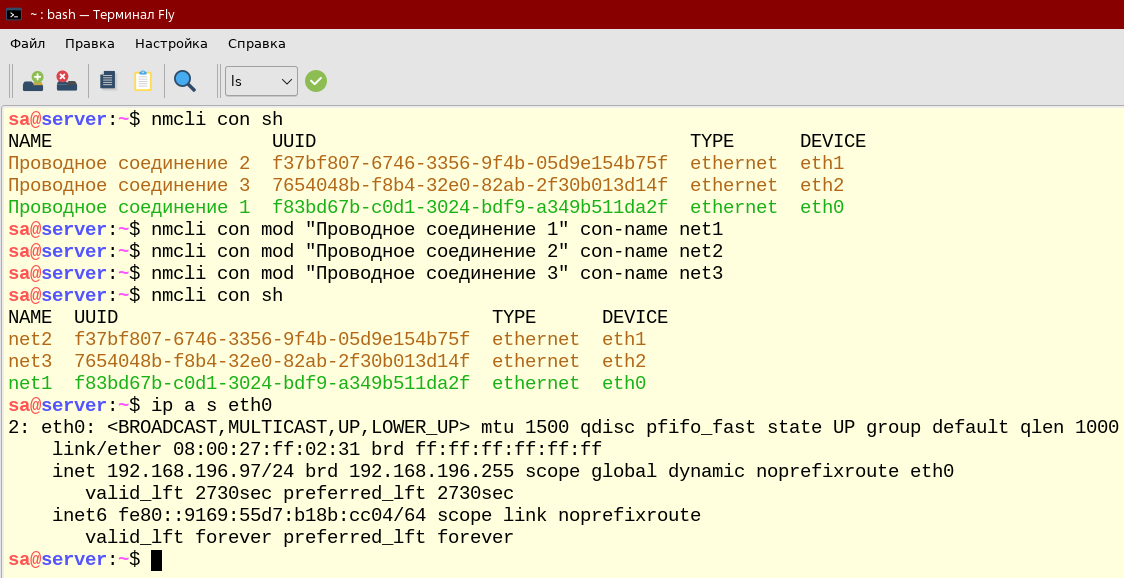

Настраиваем соединение net2 (IP-адрес 192.168.1.10/24) и проверяем, что настройка сетевого соединения произведена успешно.

In [ ]:
```bash
nmcli con mod net2 ipv4.addresses 192.168.1.10/24 ipv4.method manual
nmcli con up net2
ip a s eth1
```

Включаем внутреннюю маршрутизацию.

In [ ]:
```bash
sudo sysctl -w net.ipv4.ip_forward=1
```

Настраиваем автоматическое включение маршрутизации при загрузке системы путем внесения изменений в файл /etc/sysctl.conf.

In [ ]:
```bash
sudo vim /etc/sysctl.conf

net.ipv4.ip_forward=1
```

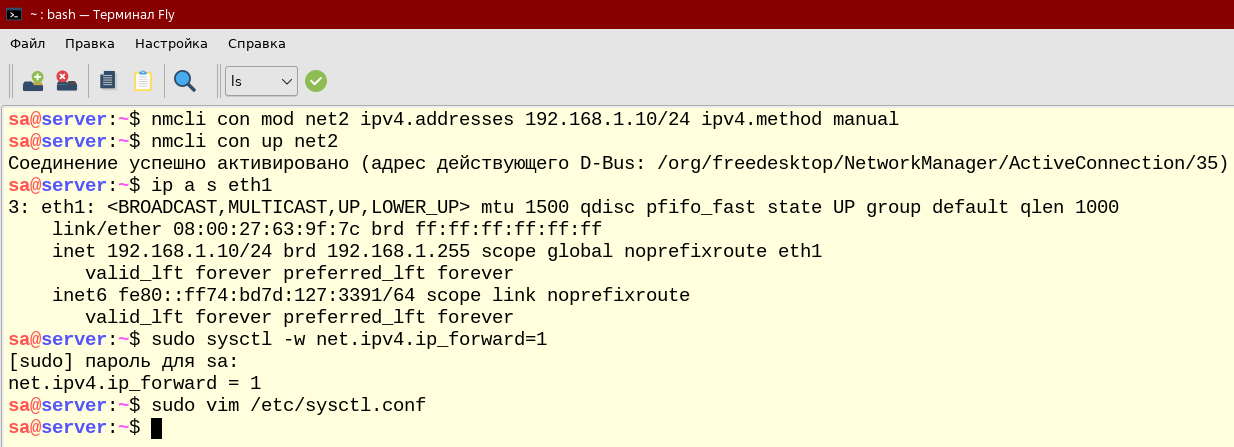

Далее настраиваем ВМ **client** c IP 192.168.1.20.

В свойствах ВМ в подразделе Network активируем один адаптер:
Adapter 1: Internal Network

Меняем имя хоста ВМ на **client**.


In [ ]:
```bash
sudo hostnamectl set-hostname client
```

Добавляем в файл /etc/hosts запись о **client**.

In [ ]:
```bash
sudo vim /etc/hosts

127.0.0.1		localhost
192.168.1.20	client
```

Останавливаем и запрещаем запуск NetworkManager.

In [ ]:
```bash
sudo systemctl stop NetworkManager
sudo systemctl mask NetworkManager
```

Настраиваем сетевой интерфейс eth0 в файле /etc/network/interfaces.

In [ ]:
```bash
sudo vim /etc/networkinterfaces

auto eth0
iface eth0 inet static
    address 192.168.1.20/24
    gateway 192.168.1.10
```

Перезапускаем службу и проверяем настройки сетевого интерфейса и доступность шлюза **server**.

In [ ]:
```bash
sudo systemctl restart networking
ip a s eth0
ping -c4 192.168.1.10
```

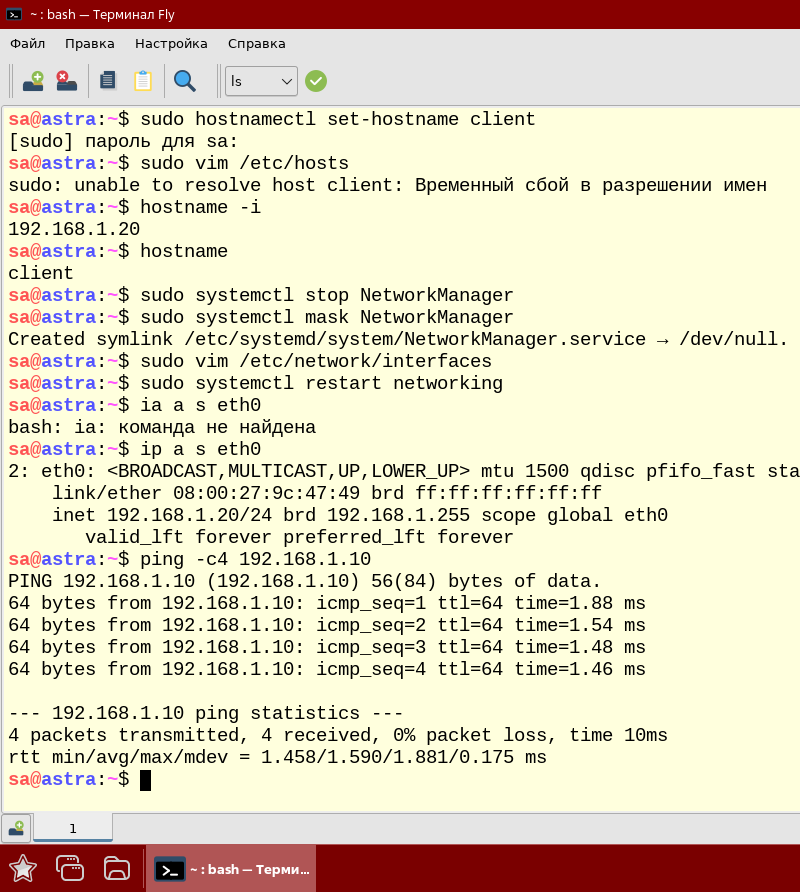

Далее на ВМ **server** настроим агрегацию Ethernet интерфейсов с использованием NetwotkManager.

Убираем настройки и отключаем сетевое соединение net2.


In [ ]:
```bash
nmcli con mod net2 ipv4.method auto
nmcli con down net2
```

Создаем логический ведущий (master) интерфейс типа bond с именем сетевого интерфейса bond0 с помощью NetworkManager.

In [ ]:
```bash
nmcli con add type bond ifname bond0
```

Настраиваем Ethernet интерфейсы eth1 и eth2 как подчиненные (slave) интерфейсы.

In [ ]:
```bash
nmcli con add type ethernet ifname eth1 master bond0
nmcli con add type ethernet ifname eth2 master bond0
```

Определяем название сетевого соединения типа bond.

In [ ]:
```bash
nmcli con sh
```

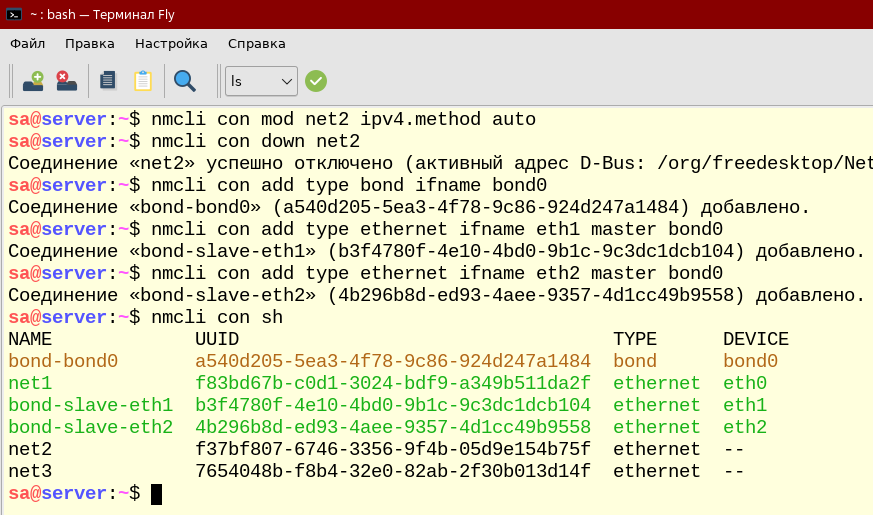

Настраиваем статический адрес 192.168.1.10 на интерфейсе bond0.

In [ ]:
```bash
nmcli con mod bond-bond0 ipv4.addr 192.168.1.10/24 ipv4.method manual
```

Активируем настройки bond0.

In [ ]:
```bash
nmcli con up bond-bond0
```

Проверяем, что интерфейс bond0 настроен и ВМ client доступна.

In [ ]:
```bash
ip a s bond0
ping -с4 192.168.1.20
```

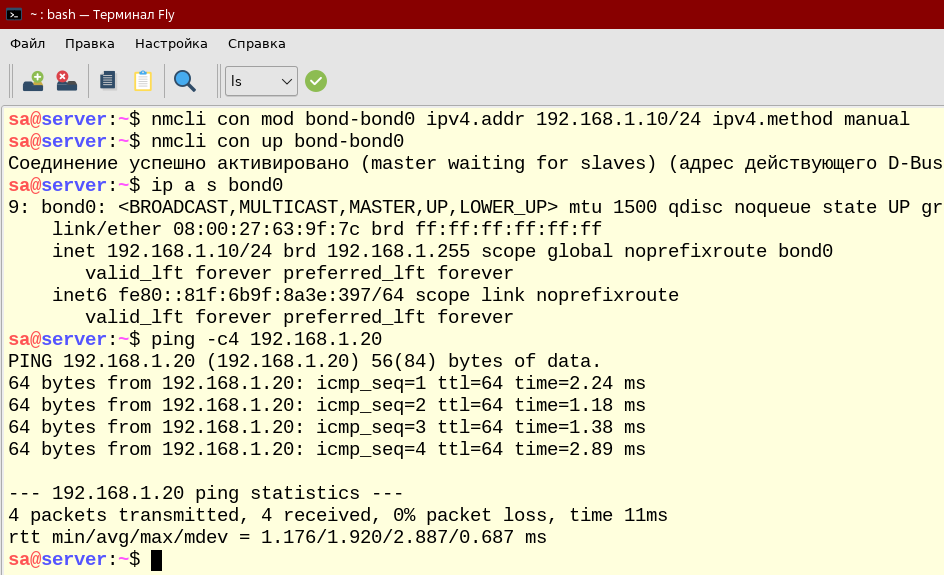

Включаем на интерфейсе bond0 режим «активный-резервный».

In [ ]:
```bash
nmcli con mod bond-bond0 bond.options mode=active-backup
```

Включаем на интерфейсе bond0 режим переназначения МАС адреса на активный интерфейс.

In [ ]:
```bash
nmcli con mod bond-bond0 +bond.options fail_over_mac=1
```

Активируем изменения на интерфейсе bond0 и проверяем, что режимы агрегирования настроены верно.

In [ ]:
```bash
nmcli con up bond-bond0
nmcli con sh bond-bond0 | grep bond
```

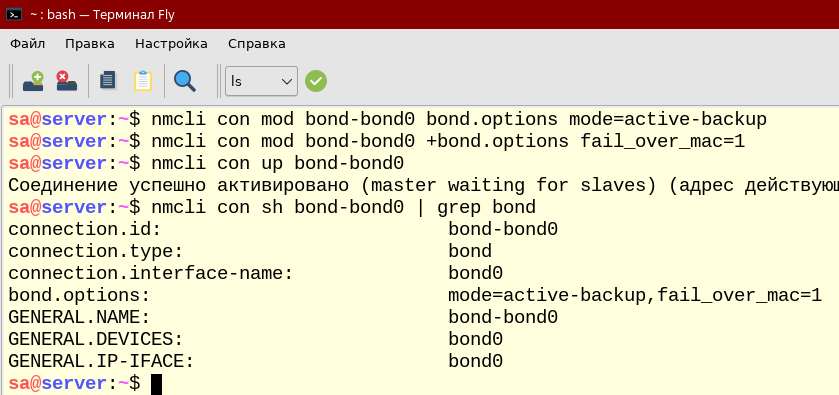

Настроим удаленный доступ между **server** и **client** с помощью протокола SSH.

На ВМ **client** проверим статус службы SSH.


In [ ]:
```bash
sudo systemctl status ssh
```

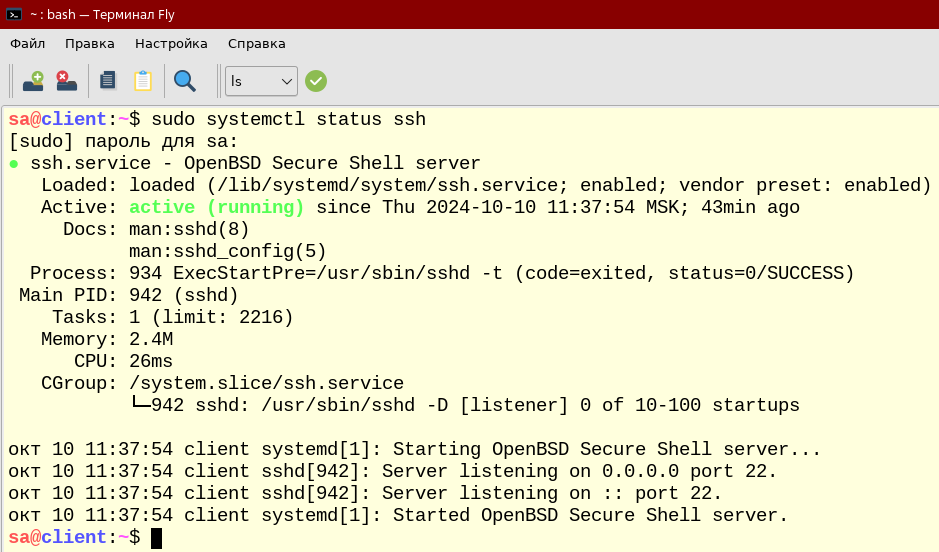

На ВМ **server** настроим аутентификацию по ключам с ВМ **client** под учетными записями sa на обоих ВМ.

In [ ]:
```bash
ssh-keygen
ssh-copy-id sa@192.168.1.20
```

Результаты выполнения команд представлены на следующей странице.

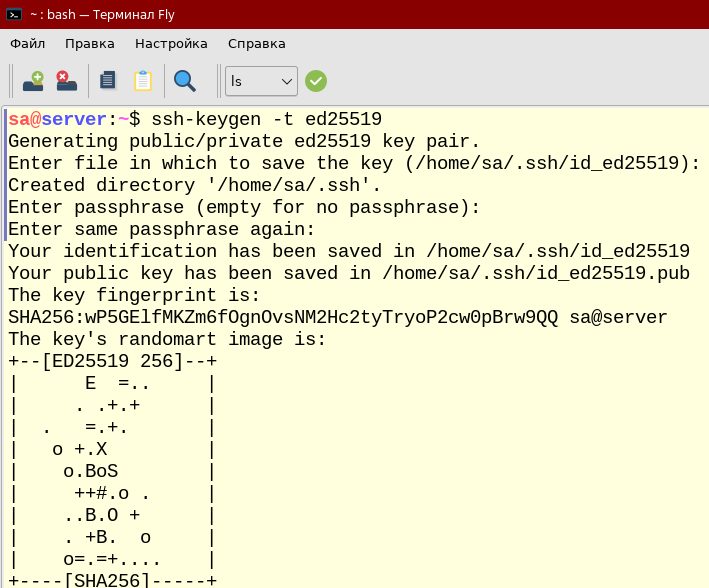

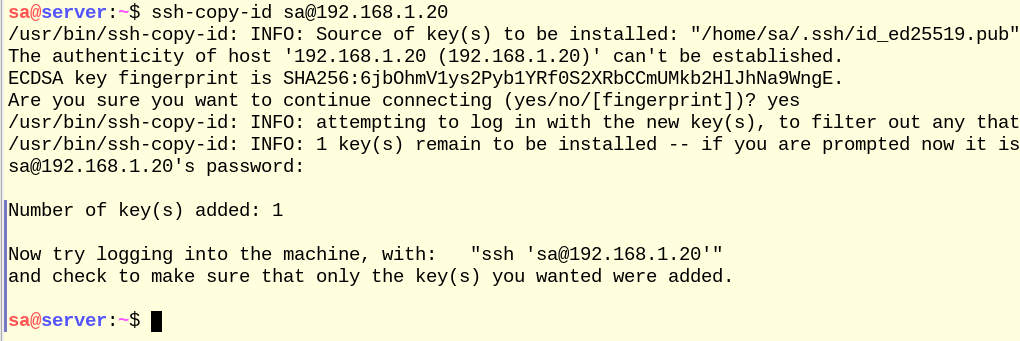

Проверим возможность подключения по протоколу SSH с ВМ **server** на ВМ **client**.

In [ ]:
```bash
ssh sa@192.168.1.20
exit
```

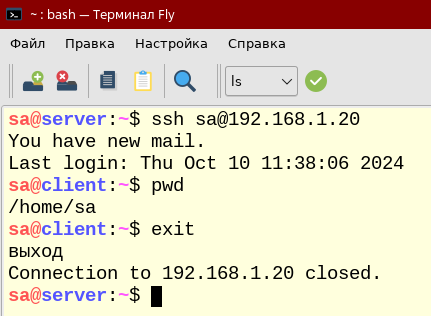

Для того, чтобы иметь возможность обновлять ПО на ВМ **client** настроим SOCKS-прокси с помощью SSH-туннеля через ВМ **server**.

На ВМ **client** настраиваем динамическую переадресацию (SOCKS-прокси) на ВМ **server** и проверяем, что SOCKS-прокси запустился.


In [ ]:
```bash
ssh -fN -D 1080 192.168.1.10
ss -tln | grep 1080
```

На ВМ **client** настроим работу утилиты apt через SOCKS-прокси: создаем файл 70proxy и добавляем в него необходимые настройки.

In [ ]:
```bash
sudo vim /etc/apt/apt.conf.d/70proxy

Acquire::https::Proxy "socks5h://127.0.0.1:1080";
Acquire::http::Proxy "socks5h://127.0.0.1:1080";
```

Проверяем, что работа утилиты apt настроена через SOCKS-прокси.

In [ ]:
```bash
sudo apt update
```

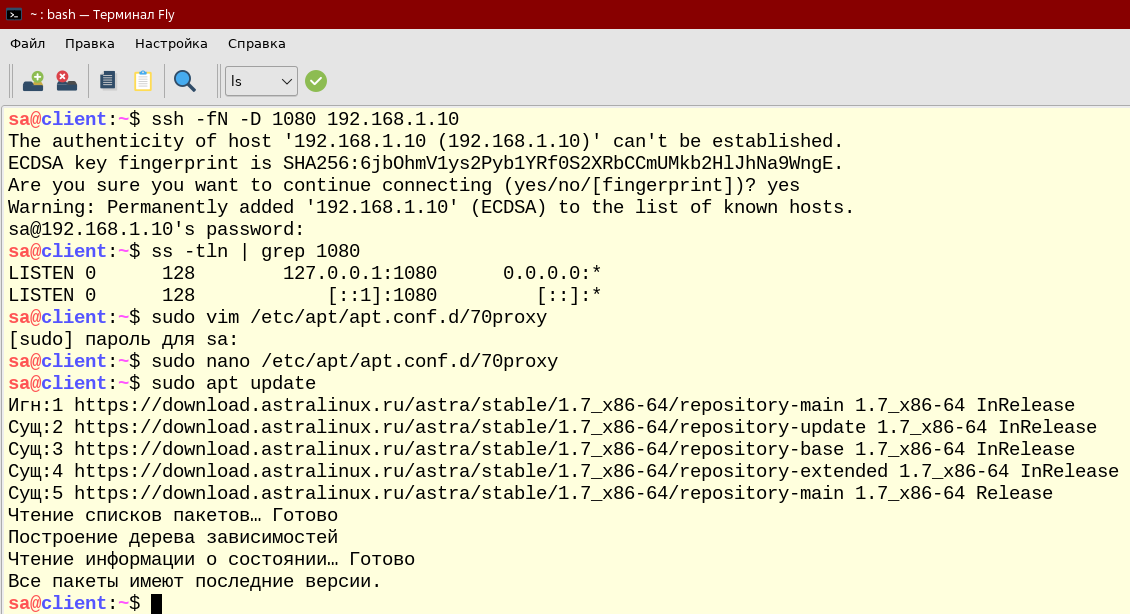

Обновлять ПО на ВМ **client** возможно через SOCKS-прокси, но интернет на машине отсутствует. Настроим передачу интернета на ВМ **client** через ВМ **server** с помощью прокси-сервера SQUID.

Устанавливаем SQUID на ВМ **server**.

In [ ]:
```bash
sudo apt install squid
```

Сохраняем исходный вариант конфигурационного файла SQUID.

In [ ]:
```bash
cd /etc/squid
sudo ср squid.conf squid.conf.orig
```

В режиме root на основе исходного конфигурационного файла SQUID создаем новый конфигурационный файл, исключив комментарии и пустые строки, содержащиеся в исходном файле.

In [ ]:
```bash
sudo -i
cd /etc/squid
cat squid.conf.orig | grep -v '^#' | grep -v '^$' > squid.conf
exit
```

Создаем в конфигурационном файле /etc/squid/squid.conf список управления доступом типа src с именем localnet, добавив в этот список управления доступом все хосты из сети 192.168.1.0/24.

In [ ]:
```bash
sudo vim /etc/squid/squid.conf

acl localnet src 192.168.1.0/24
```

Включаем в /etc/squid/squid.conf правило, разрешающее хостам, определенным в списке управления доступом localnet, обращаться к прокси-серверу. Важно, чтобы правило было размещено до запрещающего правила http_access deny all.

In [ ]:
```bash
http_access allow localnet
```

Перечитаем измененный конфигурационный файл /etc/squid/squid.conf.

In [ ]:
```bash
sudo squid -k reconfigure
```

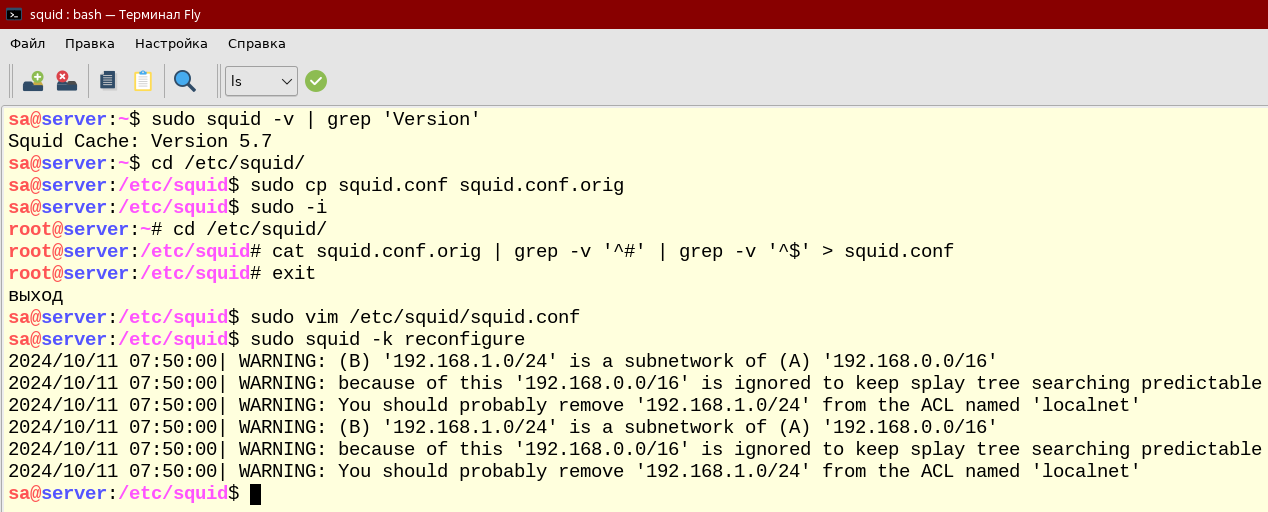

Настраиваем прокси-сервер в браузере firefox на ВМ **client**.

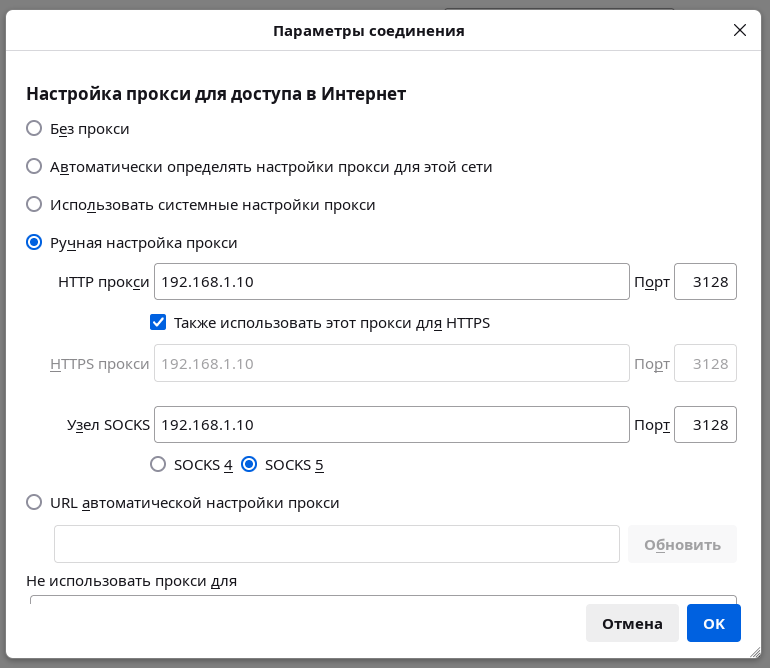

## <font color='green'>**2 Настройка сервера NFS**</font>

---

На ВМ **server** устанавливаем пакет nfs-kernel-server.

In [ ]:
```bash
sudo apt update
sudo apt install nfs-kernel-server
```

На ВМ **client** устанавливаем пакет nfs-common.

In [ ]:
```bash
sudo apt update
sudo apt install nfs-common
```

Каталогом для экспорта на ВМ **server** будет /var/home, создадим его. Дадим права на чтение, запись и исполнение всем пользователям.

In [ ]:
```bash
cd /var/
sudo mkdir home
sudo chmod 777 /var/home
```

На ВМ **server** и ВМ **client** устанавливаем пакет autofs.

In [ ]:
```bash
sudo apt update
sudo apt install autofs
```

На ВМ **client** отредактируем файл /etc/auto.master (включаем строку /home /etc/auto.home)

In [ ]:
```bash
sudo vim /etc/auto.master

/home /etc/auto.home
```

На ВМ **server** добавим в конфигурационный файл /etc/exports информацию по разрешению доступа.

In [ ]:
```bash
sudo nano /etc/exports

/var/home 192.168.1.20(rw,nohide,all_squash,anonuid=1000,anongid=1000,no_subtree_check)
sudo exportfs -ra
```

Проверим список доступных для монтирования на ВМ **client** ресурсов.

In [ ]:
```bash
sudo showmount -e 192.168.1.10
```

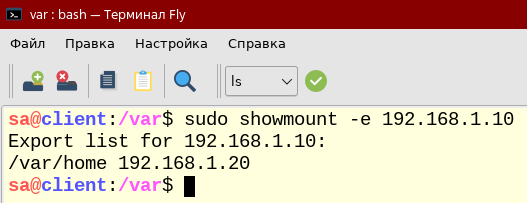

На ВМ **client** создаем каталог /mnt/nfs/ и монтируем в него ранее созданный на ВМ **server** каталог /var/home.

In [ ]:
```bash
cd /mnt/
sudo mkdir nfs
sudo mount 192.168.1.10:/var/home /mnt/nfs
```

Проверяем успешность монтирования на ВМ **client**.

In [ ]:
```bash
mount | grep nfs
df -h
```

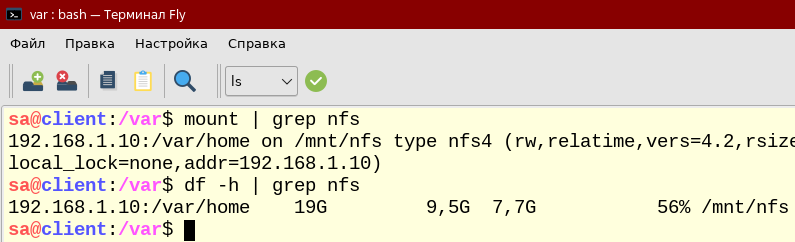

На ВМ **client** в каталоге /mnt/nfs создаем каталог sa.

In [ ]:
```bash
sudo mkdir -p /mnt/nfs/sa
```

на ВМ **client** копируем рекурсивно содержимое домашнего каталога пользователя в созданный каталог.

In [ ]:
```bash
sudo cp -r /home/sa /mnt/nfs/sa
```

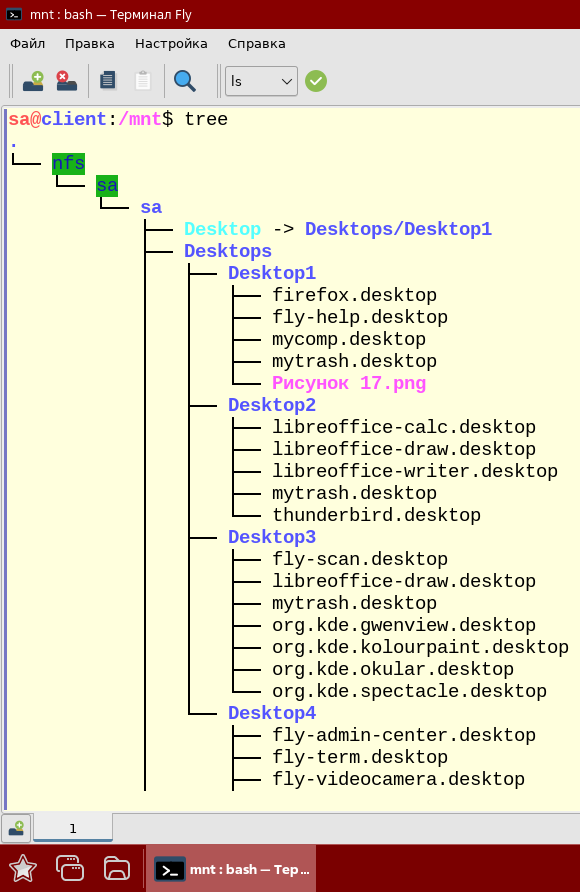

На ВМ **client** создаем файл /etc/auto.home и вносим в него необходимую корректировку.

In [ ]:
```bash
sudo touch /etc/auto.home
sudo vim /etc/auto.home

sa 192.168.1.10:/var/home/sa
```

На ВМ **client** перезапускаем службу autofs.

In [ ]:
```bash
sudo systemctl restart autofs
```

Выходим из системы ВМ **client** и повторно заходим. Проверяем монтирование каталога

In [ ]:
```bash
df -h
```

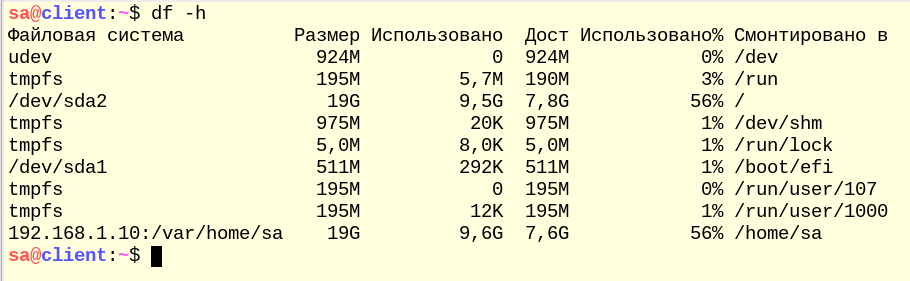

## <font color='green'>**3 Настройка сервера Samba**</font>

---

На ВМ **server** и на ВМ **client** устанавливаем пакет samba.

In [ ]:
```bash
sudo apt update
sudo apt install samba -y
```

На обоих ВМ, – **server** и **client**, – устанавливаем пакеты autofs (для автоматического подмантирования) и cifs-utils (необходим для того, чтобы **client** мог подключиться к серверу samba)

In [ ]:
```bash
sudo apt update
sudo apt install autofs -y
sudo apt install cifs-utils -y
```

По умолчанию в Linux-системах «раздаваемые» ресурсы должны находиться в каталоге /srv. Создаем на ВМ **server** каталог, который будет «раздаваемым» ресурсом для внешних клиентов.

In [ ]:
```bash
sudo mkdir -p /srv/samba/private
```

На ВМ **client** необходимо создать точку (каталог), в которую будем монтировать разделяемый ресурс с Samba сервера.

In [ ]:
```bash
sudo mkdir -p /mnt/share
```

На ВМ **server** создаем группу smbgrp.

In [ ]:
```bash
sudo groupadd smbgrp
```

На ВМ **server** создаем пользователя user1 и добавляем его в группу smbgrp.

In [ ]:
```bash
sudo useradd user1
sudo usermod -aG smbgrp user1
```

На ВМ **server** изменим групповое владение каталогом /srv/samba/private на smbgr.

In [ ]:
```bash
sudo chgrp smbgrp /srv/samba/private
```

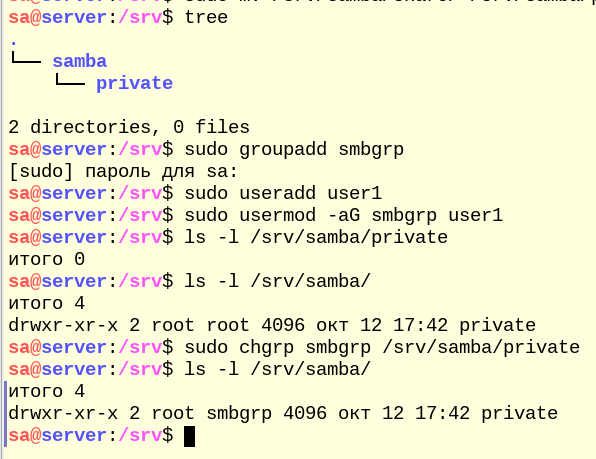

Предоставим права пользователям до разделяемого ресурса, созданного на ВМ **server**.

In [ ]:
```bash
sudo chmod 777 /srv/samba/private
```

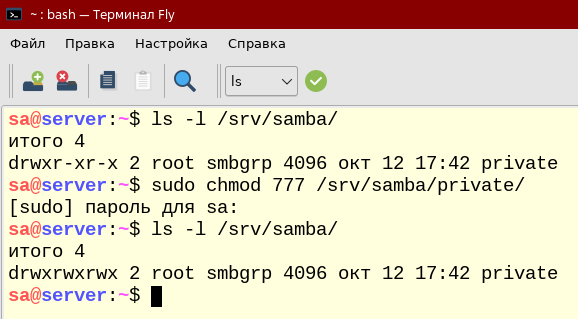

На ВМ **server** задаем пароль для пользователя user1.

In [ ]:
```bash
sudo smbpasswd -a user1
```

Активируем пользователя user1 на ВМ **server**.

In [ ]:
```bash
sudo smbpasswd -e user1
```

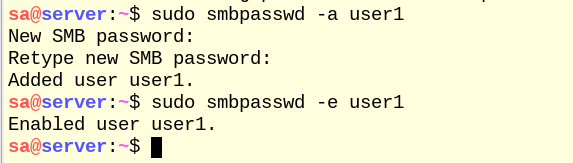

На ВМ **server** настраиваем общий доступ к каталогу /srv/samba/private по протоколу smb, для чего вносим изменения в файл конфигурации /etc/samba/smb.conf.

In [ ]:
```bash
sudo vim /etc/samba/smb.conf

[private]
		comment = private
		path = /srv/samba/private
		guest ok = no
		browsable = no
		read only = no
		create mask = 0755
```

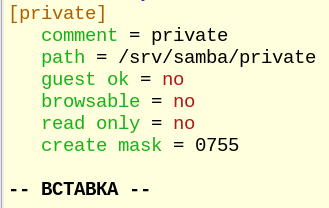

Далее на ВМ **server** необходимо запустить службу smb и перезапустить ее.

In [ ]:
```bash
sudo systemctl enable smbd
sudo systemstl start smbd
```

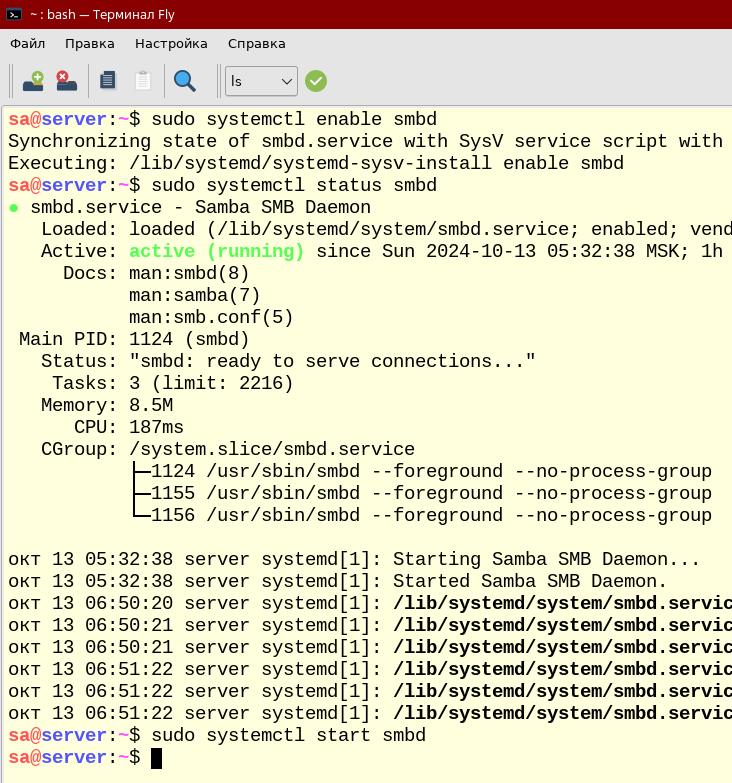

Переходим на ВМ **client** и производим ее донастройку. Ранее на этой ВМ был установлен пакет автомонтирования файловой системы autofs, на текущем этапе требуется произвести его конфигурацию: указываем, куда будем монтировать различные внешние файловые системы (в частности, куда будет подключаться ресурс с Samba сервера) и какой конфигурационный файл за данное подключение будет отвечать.

In [ ]:
```bash
sudo vim /etc/auto.master

+auto.master
/mnt/share     /etc/auto.mysmb
```

На ВМ **client** создаем конфигурационный файл mysmb. Указываем в конфигурационном файле папку, которую необходимо создавать, и что будем в нее подключать.

In [ ]:
```bash
sudo nano /etc/auto.mysmb

private -fstype=cifs,username=user1,password=********* ://192.168.1.10/private
```

На ВМ **client** перезапускаем службу автоматического монтирования.

In [ ]:
```bash
sudo systemctl restart autofs.service
```

Переходим в каталог /mnt/share/private и проверяем, что сетевой диск успешно смонтирован.

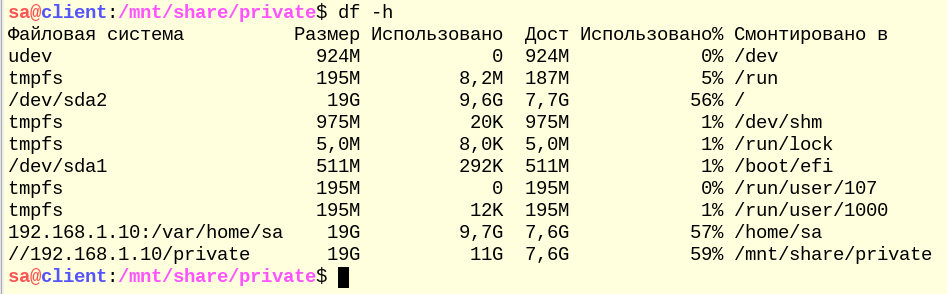

## <font color='mediumblue'>**РЕЗУЛЬТАТЫ**</font>

---

* Настроены две виртуальные машины: с ролью **server** и ролью **client**.

* Настроено удаленное защищенное соединение виртуальных машин с помощью протокола **SSH**.

* На виртуальной машине **client** настроен **SOCKS**-прокси с помощью **SSH**-туннеля через виртуальную машину **server** с целью обеспечения возможности обновлять ПО на виртуальной машине **client** посредством утилиты **apt**.

* Для настройки доступа к сети Интернет на виртуальной машине **client** настроен прокси-сервер **SQUID** через виртуальную машину **server**.

* В рамках настройки сервера **NFS** реализовано монтирование папки **/var/home** виртуальной машины **server** в папку **/mnt/nfs/sa** виртуальной машины **client**.

* В рамках настройки сервера **Samba** на виртуальной машине **server** создан каталог **/srv/samba/private** в качестве "раздаваемого" ресурса для внешних клиентов.
